In [1]:
!pip install --no-index -U --find-links=/kaggle/input/deeptables-dependecies deeptables==0.2.5

Looking in links: /kaggle/input/deeptables-dependecies
Processing /kaggle/input/deeptables-dependecies/deeptables-0.2.5-py3-none-any.whl
Processing /kaggle/input/deeptables-dependecies/hypernets-0.3.0-py3-none-any.whl (from deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/XlsxWriter-3.1.9-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/paramiko-3.3.1-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/bcrypt-4.0.1-cp36-abi3-manylinux_2_28_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)


In [96]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np 
import pandas as pd 
import polars as pl 
import matplotlib.pyplot as plt 
import seaborn as sns
import holidays
import lightgbm as lgb
import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets
import joblib

print('Tensorflow version:', tf.__version__)
print('DeepTables version:', dt.__version__)

# large number of warnings in data processing step
import warnings
warnings.filterwarnings("ignore")


# fast ai libraries
from fastai.tabular.all import *

# constants
SEED = 2024 # global seed for notebook
BATCH_SIZE = 1024
EPOCHS = 20

#library from Yelim
from statsmodels.tsa.stattools import acf, pacf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


Tensorflow version: 2.13.0
DeepTables version: 0.2.5


In [ ]:
seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=seed)

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
clean_memory()

In [97]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np 
import pandas as pd 
import polars as pl 
import matplotlib.pyplot as plt 
import holidays


from datetime import timedelta

In [98]:
class DataStorage:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
        "prediction_unit_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = self.df_electricity_prices.with_columns(
            self.df_electricity_prices['euros_per_mwh'].abs().alias('euros_per_mwh')
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )
        
    def run(self): # roll -1hr, for only T & T_d
        #self.df_data = self.fill_target(self.df_data)
        self.df_forecast_weather = self.fill_radiation(self.df_forecast_weather)
        self.df_forecast_weather = self.fill_summertime(self.df_forecast_weather)
        self.df_forecast_weather = self.separateTP(self.df_forecast_weather)
        self.df_forecast_weather = self.expForecastHr(self.df_forecast_weather)
        self.df_historical_weather = self.snow2water(self.df_historical_weather)
        self.df_historical_weather = self.histRoll(self.df_historical_weather)
        
        return self.df
    
        
#     def fill_target(self, df):
#         def _interpolate_group(group):
#             group['target'] = group['target'].interpolate(method='linear')
#             return group
#         return pl.DataFrame(df.to_pandas().groupby(['prediction_unit_id', 'is_consumption']).apply(_interpolate_group))

    def fill_radiation(self, df):
        rad = df.to_pandas()['surface_solar_radiation_downwards'].values
        idx = df['surface_solar_radiation_downwards'].is_null().to_numpy().nonzero()[0]
        for i, ind in enumerate(idx):
            tmp = df[idx][i]
            df_b1 = df.filter(
                pl.col('latitude')==tmp['latitude'], pl.col('longitude')==tmp['longitude'],
                abs(pl.col('forecast_datetime') - tmp['forecast_datetime']) < timedelta(days=2),
                pl.col('forecast_datetime').dt.hour() == tmp['forecast_datetime'].dt.hour(),
                pl.col('hours_ahead') == tmp['hours_ahead'])
            fillValue = df_b1['direct_solar_radiation'][1] / ((np.divide(df_b1['direct_solar_radiation'][0], df_b1['surface_solar_radiation_downwards'][0]) +
                np.divide(df_b1['direct_solar_radiation'][2], df_b1['surface_solar_radiation_downwards'][2]))/2)
            rad[ind] = fillValue
        df.replace('surface_solar_radiation_downwards', pl.Series(rad))
        return df

    def fill_summertime(self, df):
        missingDate = list(set(pd.date_range('2021-09-01', '2023-06-02', freq='h')[3:-22]) - set(df.to_pandas()['forecast_datetime'].unique()))
        hrs_ahead = 2
        add_df = pd.DataFrame()
        for date in missingDate:
            tmp = df.filter(abs(pl.col('forecast_datetime') - date) < timedelta(hours=2),
                            pl.col('hours_ahead') <= 2).sort('latitude', 'longitude').to_pandas()
            for _, row in tmp.iterrows():
                if row['hours_ahead'] == 1:
                    values_1 = row
                elif row['hours_ahead'] == 2:
                    values_2 = row
                    average_values = pd.Series([(v1+v2)/2 if c != 'forecast_datetime' else date for (v1,v2,c) in zip(values_1,values_2,values_2.keys())],
                                            index=values_2.keys())
                    average_values['hours_ahead'] = hrs_ahead
                    add_df = pd.concat([add_df, average_values.to_frame().T]).reset_index(drop=True)
        return pl.DataFrame(pd.concat([df.to_pandas(), add_df]).reset_index(drop=True))

    def snow2water(self, df): # for historical: [cm]/7->[mm]
        df = df.with_columns([
        (df['total_precipitation'] - df['snowfall'] / 100).alias('rain')
    ])
        return df

    def separateTP(self, df): 
    # Adjust the indentation as needed to match the rest of your class
        df = df.with_columns([
            (df['total_precipitation'] - df['snowfall'] / 100).alias('rain')
        ])
        return df

    def expForecastHr(self, df):
    # Ensure the indentation here matches the rest of your class
        def _exp(x):
            return np.exp(x) / np.exp(48)

        df = df.with_columns([
            df['hours_ahead'].apply(_exp).alias('exp_hours_ahead')
        ])
        return df
    
    def histRoll(self, df): # roll -1hr, for only T & T_d
        df = df.with_columns([
            df['temperature'].shift(-1).alias('temperature')
        ])
        df = df.with_columns([
            df['dewpoint'].shift(-1).alias('dewpoint')
        ])
        return df

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

In [99]:
class FeaturesGenerator:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            #.filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                #.filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

#     def _add_target_features(self, df_features):
#         df_target = self.data_storage.df_target

#         df_target_all_type_sum = (
#             df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
#             .sum()
#             .drop("product_type")
#         )

#         df_target_all_county_type_sum = (
#             df_target.group_by(["datetime", "is_business", "is_consumption"])
#             .sum()
#             .drop("product_type", "county")
#         )

#         for hours_lag in [
#             2 * 24,
#             3 * 24,
#             4 * 24,
#             5 * 24,
#             6 * 24,
#             7 * 24,
#             8 * 24,
#             9 * 24,
#             10 * 24,
#             11 * 24,
#             12 * 24,
#             13 * 24,
#             14 * 24,
#             6,      ###
#             12,     ###
#             84,     ###
#             3096,   ### add juwon
#         ]:
#             df_features = df_features.join(
#                 df_target.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_{hours_lag}h"}),
#                 on=[
#                     "county",
#                     "is_business",
#                     "product_type",
#                     "is_consumption",
#                     "datetime",
#                 ],
#                 how="left",
#             )

#         for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
#             df_features = df_features.join(
#                 df_target_all_type_sum.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
#                 on=["county", "is_business", "is_consumption", "datetime"],
#                 how="left",
#             )

#             df_features = df_features.join(
#                 df_target_all_county_type_sum.with_columns(
#                     pl.col("datetime") + pl.duration(hours=hours_lag)
#                 ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
#                 on=["is_business", "is_consumption", "datetime"],
#                 how="left",
#                 suffix=f"_all_county_type_sum_{hours_lag}h",
#             )

#         cols_for_stats = [
#             f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
#         ]
#         df_features = df_features.with_columns(
#             df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
#             df_features.select(cols_for_stats)
#             .transpose()
#             .std()
#             .transpose()
#             .to_series()
#             .alias(f"target_std"),
#         )

#         for target_prefix, lag_nominator, lag_denomonator in [
#             ("target", 24 * 7, 24 * 14),
#             ("target", 24 * 2, 24 * 9),
#             ("target", 24 * 3, 24 * 10),
#             ("target", 24 * 2, 24 * 3),
#             ("target_all_type_sum", 24 * 2, 24 * 3),
#             ("target_all_type_sum", 24 * 7, 24 * 14),
#             ("target_all_county_type_sum", 24 * 2, 24 * 3),
#             ("target_all_county_type_sum", 24 * 7, 24 * 14),
#         ]:
#             df_features = df_features.with_columns(
#                 (
#                     pl.col(f"{target_prefix}_{lag_nominator}h")
#                     / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
#                 ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
#             )

#         return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
           "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            #self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

In [92]:
def convert_2_dataloader(df, _seed):

    # define categorical and continous numerical feature column names (on small number of features)
    # from train.csv
    cat_names = ["county", "is_business", "product_type", "is_consumption", "segment"]
    # from datetime column
    cat_names += ["weekday", "month", 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)']
    # from https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79 notebook
    cat_names += ['country_holiday']
    
    # from client.csv
    cont_names = ["installed_capacity", "eic_count"]
    
    # from forecast_weather.csv (next 0 hours)
    cont_names += [_ for _ in df.columns if "_forecast_0h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_0h" in _]
    # from forecast_weather.csv (next 24 hours)
    cont_names += [_ for _ in df.columns if "_forecast_24h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_24h" in _]
    
    # from historical_weather.csv (last 24/48 hours)
    cont_names += [_ for _ in df.columns if "_historical_24h" in _]
    cont_names += [_ for _ in df.columns if "_historical_48h" in _]
    cont_names += [_ for _ in df.columns if "_historical_local_48h" in _]
    
    # add all historical target values (last n hours)
    cont_names += df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    cont_names += ['target_mean', 'target_std']
    
    # added aggregated target values
    cont_names += [_ for _ in df.columns if "target_all_" in _]
    
    # add ratios between last kown target values
    cont_names += df.filter(regex=("target_ratio_.[0-9]")).columns.tolist()
    
    procs = [Categorify, FillMissing, Normalize]
    
    # log transform target variable
    df.loc[:, 'target'] = np.log1p(df['target'])
        
    # convert pandas DataFrame to fastai DataLoader object
    # code snippet taken from
    # https://docs.fast.ai/tabular.learner.html
    splits = RandomSplitter(valid_pct=0.2, seed = _seed)(df)
    
    # tabular object (only categorical features)
    to = TabularPandas(df[cat_names + cont_names + ["target"]],
                       procs = procs,
                       cat_names = cat_names,
                       cont_names = cont_names,
                       y_names = ["target"],
                       splits=splits)
    # create dataloader
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dls = to.dataloaders(BATCH_SIZE, device = device)
     
    # return all dataloaders as tuple
    return dls

def add_custom_features(df):
    """
    Function inspired by notebook:
    https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79
    """
    
    # code bellow same as in NB v17 add_holidays_as_binary_features function
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
    estonian_holidays = [pd.to_datetime(_) for _ in estonian_holidays.keys()]
    
    df['country_holiday'] = df['date'].isin(estonian_holidays) * 1
    del df['date']
    
    # log transform histrocial target values
    _cols = df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    for _col in _cols:
        df.loc[:, _col] = np.log1p(df[_col])
    
    # log transform aggregated target values
    _cols = [_ for _ in df.columns if "target_all_" in _]
    for _col in _cols:
        df.loc[:, _col] = np.log1p(df[_col])  
    
    return df

In [113]:
class DataTransformer:
    def __init__(self, df):
        self.df = df

    def transform(self):
        self.add_season()
        self.add_daypart_with_sin_hour()
        self.add_feels_like_temperature()
        #self.add_energy_usage_trend()
        self.add_temp_change()
        self.add_prec_change()
        self.add_autocorr_features()
        self.add_energy_price_volatility_and_trend()
        #self.perform_clustering()
        self.analyze_transit_and_charging_access()
        return self.df

    def add_season(self):
        def get_season(month):
            if month in [3, 4, 5]:
                return 1 #spring
            elif month in [6, 7, 8]:
                return 2 #summer
            elif month in [9, 10, 11]:
                return 3 #fall
            else:
                return 4 #winter
        
        self.df['season'] = self.df['month'].apply(get_season)

    def add_daypart_with_sin_hour(self):
        def get_daypart(sin_hour):
            if sin_hour > 0:
                return 1  # sin(hour) 양수: 오전~오후
            else:
                return 2      # sin(hour) 음수: 저녁~밤

        self.df['daypart'] = self.df['sin(hour)'].apply(get_daypart)

    def add_feels_like_temperature(self):
        def calculate_feels_like(T, u, v):
            wind_speed = (u**2 + v**2)**0.5
            if wind_speed < 4.8:
                return T
            else:
                return 13.12 + 0.6215 * T - 11.37 * (wind_speed ** 0.16) + 0.3965 * T * (wind_speed ** 0.16)

        self.df['feels_like_temp'] = self.df.apply(lambda row: calculate_feels_like(row['temperature'], row['10_metre_u_wind_component'], row['10_metre_v_wind_component']), axis=1)


#     def add_energy_usage_trend(self, period = 7):
#         self.df['energy_trend'] = self.df['target'].rolling(window = period).mean()

    def add_temp_change(self, interval = 24):
        self.df['temp_change'] = self.df['temperature'].diff(periods = interval)

    def add_prec_change(self):
        self.df['precipitation_change'] = self.df['total_precipitation'].diff()

    def add_autocorr_features(self, lags = 10):
        acf_values = acf(self.df['target'], nlags = lags)
        pacf_values = pacf(self.df['target'], nlags = lags)
        for i in range(lags+1):
            self.df[f'acf_lag_{i}'] = acf_values[i]
            self.df[f'pacf_lag{i}'] = pacf_values[i]

    def add_energy_price_volatility_and_trend(self, window = 7):
        self.df['energy_price_volatility'] = self.df['target'].rolling(window = window).std()

    # def perform_clustering(self, n_clusters = 3, features = None):
    #     if features is None:
    #         features = ['target_24h', 'target_48h', 'temperature', 'cloudcover_total']
    #     scaler = StandardScaler()
    #     scaled_data = scaler.fit_transform(self.df[features])

    #     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    #     self.df['cluster'] = kmeans.fit_predict(scaled_data)

    def analyze_transit_and_charging_access(self):

        results = []
        for consumption_status in [0, 1]:
            subset = self.df[self.df['is_consumption'] == consumption_status]

            # 대중교통 이용률 분석
            business_hours_energy = subset[subset['is_business'] == 1]['target'].mean()
            non_business_hours_energy = subset[subset['is_business'] == 0]['target'].mean()
            transit_usage_estimate = business_hours_energy - non_business_hours_energy

            # 전기차 충전소 접근성 분석
            high_capacity_energy = subset[subset['installed_capacity'] > subset['installed_capacity'].median()]['target'].mean()
            low_capacity_energy = subset[subset['installed_capacity'] <= subset['installed_capacity'].median()]['target'].mean()
            charging_access_estimate = high_capacity_energy - low_capacity_energy

            results.append((consumption_status, transit_usage_estimate, charging_access_estimate))

        # 결과를 하나의 컬럼으로 합침
        for consumption_status, transit_estimate, charging_estimate in results:
            self.df[f'transit_usage_estimate_{consumption_status}'] = transit_estimate
            self.df[f'charging_access_estimate_{consumption_status}'] = charging_estimate

In [101]:
import numpy as np #wind  
import pandas as pd

#train_dataset data 변환 (weekday -> weekend, wind dir, speed -> U10, V10)
class TrainDataTransform:
    def __init__(self, df):
        self.df = df

    def transform(self):
        self.is_weekend()
        self.wind_data_to_UV()
        return self.df

    #weekend 판별 함수
    def is_weekend(self):
        self.df['is_weekend'] = np.where(self.df['weekday'] > 4, 1, 0)
        
    def wind_data_to_UV(self):
        self.df['U10'] = self.df['windspeed_10m'] * np.cos(np.radians(270 - self.df['winddirection_10m']))
        self.df['V10'] = self.df['windspeed_10m'] * np.sin(np.radians(270 - self.df['winddirection_10m']))
        

In [102]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

In [103]:
train_dataset = features_generator.generate_features(data_storage.df_data)
# exclude rows with missing target value
train_dataset = train_dataset[train_dataset['target'].notnull()]
# add estonian holidays
train_dataset = add_custom_features(train_dataset)

In [104]:
#이거 먼저 와야함, 예림 추가
train_dataset['eic_count'] = train_dataset['eic_count'].fillna(method = 'bfill')
train_dataset['installed_capacity'] = train_dataset['installed_capacity'].fillna(method = 'bfill')

######################## 이부분에서 missing value확인하기?

#add yelim
train_dataset = DataTransformer(train_dataset)
train_dataset = train_dataset.transform()

#add joonyong
train_dataset = TrainDataTransform(train_dataset)
train_dataset = train_dataset.transform()


### drop county == 12 , prec_change Nan,  yelim added ####
train_dataset = train_dataset[train_dataset['county'] != 12]
train_dataset = train_dataset['precipitation_change'].fillna(method='bfill')

In [ ]:
def pd_to_polars(df):
    """
    Convert a Pandas DataFrame to Polars DataFrame and handle columns
    with int and float categorical dtypes.
    """
    df = df.copy()
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if pd.api.types.is_integer_dtype(df[col].cat.categories.dtype):
                df[col] = df[col].astype(int)
                print(f"Column [{col}] cast to int")
            elif pd.api.types.is_float_dtype(df[col].cat.categories.dtype):
                df[col] = df[col].astype(float)
                print(f"Column [{col}] cast to float")

    return pl.from_pandas(df)

test2 = pd_to_polars(train_dataset)


In [ ]:
test2.filter(pl.col('prediction_unit_id') == 21,
                                   pl.col('year') == 2022,
                                   pl.col('month') == 2,
                                   pl.col('day') < 10,
                                   pl.col('is_consumption') == 1,
                                   ).to_pandas()#.value_counts('installed_capacity')

In [ ]:
from datetime import datetime

In [ ]:
data_storage.df_client.filter(pl.col('date') == datetime(2022, 2, 1),
                              pl.col('county') == 5,
                              )

In [ ]:
train_dataset.groupby(['eic_count', 'installed_capacity']).size().reset_index()

In [ ]:
test = train_dataset[train_dataset.eic_count.isnull()]
for c in test.columns:
    print(test[c].value_counts())
    print('\n')

In [ ]:
for c in data_storage.df_client.columns:
    if c != 'eic_count':
        print(c, 
              data_storage.df_client[c].value_counts())

In [ ]:
#train_dataset.to_csv('/Data/home/limkim/Enefit/Kaggle2024_Enefit/baseline.csv', index = False)

# Modeling

In [106]:
df_train_features = train_dataset[train_dataset['target'].notnull()]
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1651902 entries, 366048 to 2018351
Columns: 207 entries, county to V10
dtypes: category(5), float32(162), float64(31), int32(1), int64(5), int8(3)
memory usage: 1.5 GB


Learning Rate schedule : 1e-07 to 0.001 to 1e-07


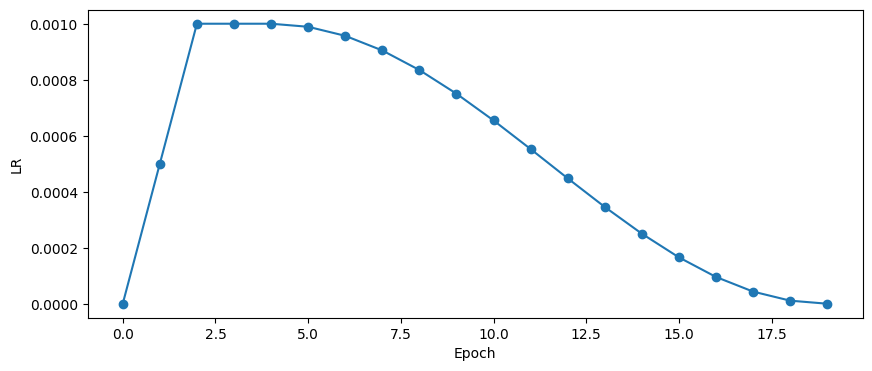

In [107]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 2
EPOCHS = 20

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10,4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print('Learning Rate schedule : {:.3g} to {:3g} to {:3g}' . \
        format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [108]:
%%time
class CFG:
    nn = True
    lgb = True
    ens_weights = {'nn': 0.5, 'lgb': 0.5}
    epochs = 10
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
     
class Model:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params = {"n_estimators": 2500,
                           "learning_rate": 0.06,
                           "max_depth": 16,
                           "num_leaves": 500,
                           "reg_alpha": 3.5,
                           "reg_lambda": 1.5,
                           "colsample_bytree": 0.9,
                           "colsample_bynode": 0.6,
                           "min_child_samples": 50,
                           "random_state": 0,
                           "objective": "regression_l1",
                           "device": "gpu",
                           "n_jobs": 4,
                           "verbose": -1,
                           }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params)

    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = df_train_features["is_consumption"] == 1
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = df_train_features["is_consumption"] == 1
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        if CFG.nn == True and CFG.lgb == True:
            
            print('\n',"nn & lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask])),
                0,
                np.inf,
            )
        
            print('\n',"nn & lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask])),
                0,
                np.inf,
            )
        
        elif CFG.nn == True and CFG.lgb == False:
            
            print('\n',"nn model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_consumption.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
            print('\n',"nn model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_production.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
        elif CFG.nn == False and CFG.lgb == True:
            
            print('\n',"lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_consumption.predict(df_features[mask]),
                0,
                np.inf,
            )
            
            print('\n',"lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_production.predict(df_features[mask]),
                0,
                np.inf,
            )
            
        else:
            raise ValueError("No models has been trained.")
            
        return predictions
    
    
model = Model()
model.fit(df_train_features)

joblib.dump(model.lgb_model_consumption, 'lgb_model_consumption.joblib')
joblib.dump(model.lgb_model_production, 'lgb_model_production.joblib')

nn_model_consumption = model.nn_model_consumption.get_model().model
nn_model_consumption.save('nn_model_consumption.h5')

nn_model_production = model.nn_model_production.get_model().model
nn_model_production.save('nn_model_production.h5')


nn = True
lgb = True

 nn model consumption training. 

01-26 03:51:59 I deeptables.m.deeptable.py 338 - X.Shape=(825951, 206), y.Shape=(825951,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7c190faba140>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.3, True), (256, 0.3, T

01-26 03:52:01 W hypernets.t.cache.py 200 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-26 03:52:01 I deeptables.m.preprocessor.py 261 - Preparing features...
01-26 03:52:04 I deeptables.m.preprocessor.py 336 - Preparing features taken 2.482285499572754s
01-26 03:52:04 I deeptables.m.preprocessor.py 341 - Data imputation...
01-26 03:52:26 I deeptables.m.preprocessor.py 383 - Imputation taken 22.28065800666809s
01-26 03:52:26 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-26 03:52:27 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 1.5595452785491943s
01-26 03:52:27 I deeptables.m.preprocessor.py 398 - Data discretization...
01-26 03:52:27 I hypernets.t.sklearn_ex.py 716 - 174 variables to discrete.
01-26 03:53:12 I deeptables.m.preprocessor.py 404 - Discretization taken 44.49142003059387s
01-26 03:53:28 I deeptables.m.preprocessor.py 196 - fit_transform taken 86.68371891975403s
01-26 03:53:28 I deeptables.m.deeptable.py 354 - Training...
01-26 03:53:28 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_m, 

01-26 04:03:19 W hypernets.t.cache.py 200 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-26 04:03:19 I deeptables.m.preprocessor.py 261 - Preparing features...
01-26 04:03:20 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.8199238777160645s
01-26 04:03:20 I deeptables.m.preprocessor.py 341 - Data imputation...
01-26 04:03:43 I deeptables.m.preprocessor.py 383 - Imputation taken 22.675670385360718s
01-26 04:03:43 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-26 04:03:45 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 1.6144566535949707s
01-26 04:03:45 I deeptables.m.preprocessor.py 398 - Data discretization...
01-26 04:03:45 I hypernets.t.sklearn_ex.py 716 - 175 variables to discrete.
01-26 04:04:27 I deeptables.m.preprocessor.py 404 - Discretization taken 42.30223751068115s
01-26 04:04:42 I deeptables.m.preprocessor.py 196 - fit_transform taken 83.66532897949219s
01-26 04:04:42 I deeptables.m.deeptable.py 354 - Training...
2 Physical GPUs, 2 Logical GPUs
01-26 04:04:44 I deeptables.u.dataset_generator.py 240 - create dat

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.



 lgb model production training. 

CPU times: user 3h 57min 4s, sys: 4min 10s, total: 4h 1min 14s
Wall time: 1h 21min 36s


In [ ]:
# # 저장되어있는 모델 사용하는 경우

# lgb_model_consumption = joblib.load('lgb_model_consumption.joblib')
# lgb_model_production = joblib.load('lgb_model_production.joblib')

# from tensorflow.keras.models import load_model
# model_file = 'nn_model_production.h5'
# loaded_model = load_model(model_file)

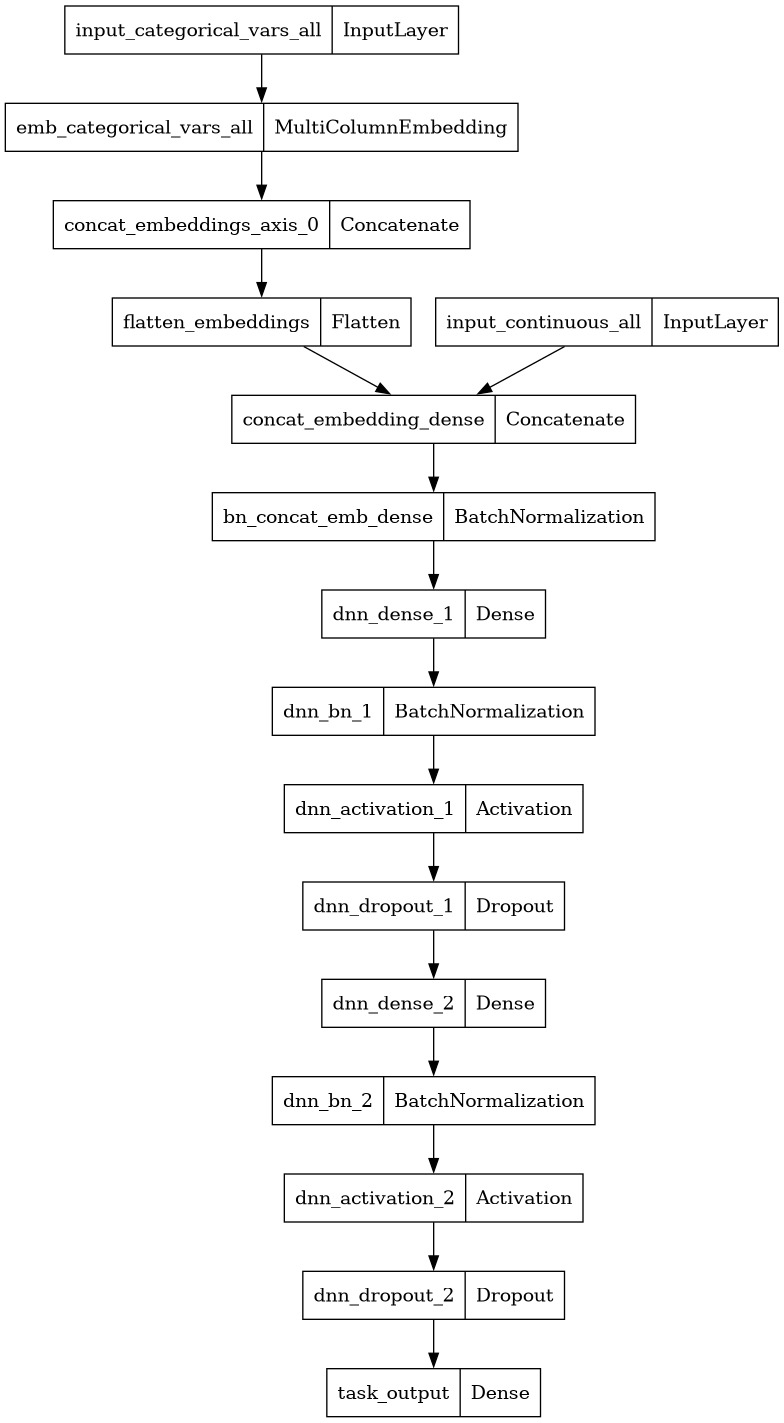

In [109]:
clean_memory()
model.plot_nn_model()

# Submit API

In [110]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [117]:
%%time
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:

    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    df_test = data_storage.preprocess_test(df_test)
    df_test = data_storage.run(df_test)
    
    df_test = features_generator.generate_features(df_test)
    df_test = df_test[df_test['target'].notnull()]
    df_test = add_custom_features(df_test)

    #이거 먼저 와야함, 예림 추가
    df_test['eic_count'] = df_test['eic_count'].fillna(method = 'bfill')
    df_test['installed_capacity'] = df_test['installed_capacity'].fillna(method = 'bfill')
    #add yelim
    df_test = DataTransformer(df_test)
    df_test = df_test.transform()
    #add joonyong
    df_test = TrainDataTransform(df_test)
    df_test = df_test.transform()
    ### drop county == 12 , prec_change Nan,  yelim added ####
    df_test = df_test[df_test['county'] != 12]
    df_test_features = df_test['precipitation_change'].fillna(method='bfill')
    
    prec = model.predict(df_test_features)
    
    
    df_sample_prediction["target"] = prec
    env.predict(df_sample_prediction)

You must call `predict()` successfully before you can continue with `iter_test()`


TypeError: cannot unpack non-iterable NoneType object

In [120]:
prec[:10]

NameError: name 'prec' is not defined

In [121]:
test = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/test.csv')
test.head()

,county,is_business,product_type,is_consumption,prediction_datetime,data_block_id,row_id,prediction_unit_id,currently_scored
0,0,0,1,0,2023-05-28 00:00:00,634,2005872,0,False
1,0,0,1,1,2023-05-28 00:00:00,634,2005873,0,False
2,0,0,2,0,2023-05-28 00:00:00,634,2005874,1,False
3,0,0,2,1,2023-05-28 00:00:00,634,2005875,1,False
4,0,0,3,0,2023-05-28 00:00:00,634,2005876,2,False


In [122]:
train = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
